<a href="https://colab.research.google.com/github/ajaynain-eng/2D-to-3D-CNN-Pivotal-Teleradiology/blob/main/Data_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# http://openi.nlm.nih.gov/imgs/collections/ChinaSet_AllFiles.zip

In [2]:
 import os
 os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [3]:
!kaggle datasets download -d ymirsky/medical-deepfakes-lung-cancer 

100% 5.99G/5.99G [01:26<00:00, 63.0MB/s]



In [4]:
!http://openi.nlm.nih.gov/imgs/collections/NLM-MontgomeryCXRSet.zip

/bin/bash: http://openi.nlm.nih.gov/imgs/collections/NLM-MontgomeryCXRSet.zip: No such file or directory


In [ ]:
!unzip \*.zip && rm *.zip

In [6]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 3.1MB/s 


In [7]:
# importing supporting libraries
import pandas as pd                    # to create and read data frame and series
import numpy as np                     # to work with array
from matplotlib import pyplot as plt   # to plot figures
import seaborn as sns                  # to plot interactive metric plot and heatmaps
import cv2                             # to read and show image
from skimage.transform import resize   # as we need to resize the image to reduce model complexity and get optimum accuracy

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

import os
import warnings
import pydicom as dicom
import glob
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# importing required CNN algorithms, optimizers and activation function
import tensorflow as tf
from tensorflow import keras
#from keras.applications import VGG16
from keras import Sequential
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPool3D, ZeroPadding3D, Dropout, BatchNormalization
from keras.layers import Flatten, Dense, Input
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras import callbacks
# importing pretrained model VGG16 and VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

import time


from skimage import measure
from skimage.transform import resize
from matplotlib.projections import Axes3D
from plotly.figure_factory import create_trisurf
from mpl_toolkits import mplot3d

In [8]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

def crop_image(image, display=False):
# Create a mask with the background pixels
    mask = image == 0
# Find the lung area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
# Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                         top_left[1]:bottom_right[1]]
    return croped_image

def no_crop(medical_img):         # changes the medical image in pixel array and returns the original image
    return medical_img.pixel_array

def crop_the_image_1(medical_img):     # crop the image corresponding to HU range for lungs
    temp_medical_img = medical_img
    temp_img = temp_medical_img.pixel_array
    hu_image = transform_to_hu(temp_medical_img,temp_img)
    lung_image = window_image(hu_image, -500, 1500)
    croped_img = crop_image(lung_image, display=False)
    return croped_img

In [9]:
def get_data(pid, crop_function):         #  Selects and crops 110 slices and give 3D and 2D image data
    files = glob.glob("/content/CT_Scans/EXP1_blind/"+ pid +"/*.dcm")
    slices = [dicom.read_file(i) for i in files]
    slices = sorted(slices, key=lambda s: s.SliceLocation)
    s = 0
    views = np.empty([110,110,110])
    x = (len(slices)-4)/109      # Select 110 slices
    for i in range(110):
        t = int(4+(x*i))
        try:
            t_img = crop_function(slices[t])
            t_img = resize(t_img, (110,110))
        except:
            t_img = crop_function(slices[t-1])
            t_img = resize(t_img, (110,110))
            s = s + 1
        views[:,:,i] = t_img          # 3D image array
        i += 1
    img_2d = views[55,:,:].T
    img_2d = img_2d[::-1]           # 2D image array
    print(s)     
    return views, img_2d

In [10]:
def get_correlation(data, threshold):
    corr_col = set()
    corr = data.corr()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i,j]) > threshold:  #if abs(corr.iloc[i,j]) > threshold:
                corr_col.add(corr.columns[i])
    return corr_col

def get_uncorr_data(train_data, test_data, threshold):
    start_time = time.time()
    correlated_block = dict()
    corr_columns = get_correlation(pd.DataFrame(train_data), threshold)
    temp_correlated_block = dict()


    corrmat = pd.DataFrame(train_data).corr()

    corrdata = corrmat.stack().sort_values(ascending = False)  #corrdata = corrmat.abs().stack().sort_values(ascending = False)

    corrdata = corrdata[corrdata > threshold]
    corrdata = corrdata[corrdata <= 1]
    corrdata = pd.DataFrame(corrdata).reset_index()
    corrdata.columns = ['feature1','feature2', 'value']

    grouped_column_list = []
    correlated_group_list = []
    for column in corrdata['feature1']:
        if column not in grouped_column_list:
            correlated_block_list = corrdata[corrdata.feature1 == column]
            grouped_column_list = grouped_column_list + list(correlated_block_list.feature2.unique()) + [column]
            correlated_group_list.append(correlated_block_list)         #  correlated_block

    important_columns = []
    for data in correlated_group_list:
        columns = list(data.feature1.unique()) + list(data.feature2.unique())
        important_columns.append(columns[0])
            

    new_to_drop = list(corr_columns - set(important_columns))

    l = new_to_drop

    columns_to_drop = list()
    for i in l:
        if i not in [0,1,108,109]:
            if (i-1 not in columns_to_drop and i+1 not in columns_to_drop):     ####
                if (i-2 not in columns_to_drop and i+2 not in columns_to_drop):
                    columns_to_drop.append(int(i))

    for col in columns_to_drop:
        corr_col = corrdata[corrdata.feature1 == col]
        temp_correlated_block =  list(corr_col.feature2.unique())
        correlated_block[str(col)] = temp_correlated_block

    col_to_drop_df = pd.concat([corrdata, pd.Series(columns_to_drop, name = 'column_to_drop')], axis = 1)
    print(f'time for get_uncorr_data : {time.time() - start_time}')
    
    return col_to_drop_df, correlated_block

In [11]:
def get_cross_val_score(col_to_drop, y_0, correlated_block): 
    start_time = time.time()   
    rf_score_mean = list()      # diff_1 = droped_col[i] - droped_col[i-1]                             
    knn_score_mean = list()     # diff_2 = droped_col[i+1] - droped_col[i] - 1
    knn_neighbors = list()      # training_col = imp_col[diff_1:-diff_2]
    neighbors = 2
    estimators = 60


    temp_y = y_0.reshape((8800, 110))
    for key, value in correlated_block.items():
        #rf = RandomForestRegressor(n_estimators=40, random_state=0)   # + y_0[0][:,j:j+1]
        #rf_score_mean.append(cross_val_score(rf, pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)]).mean()*100)
        #knn_time = time.time()
        knn_val_score = cross_val_score(KNeighborsRegressor(n_neighbors=2), pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)])

        mean = knn_val_score.mean()*100
        m = list()
        n = list()
        p = list()
        if mean < 0.995:
            for k, o in enumerate([4, 6, 8, 10, 12]):
                scr = cross_val_score(KNeighborsRegressor(n_neighbors=o), pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)])
                m.append(o)
                n.append(scr.mean())
                p.append(scr)
            max_arg = np.array(n).argmax()
            knn_neighbors.append(m[max_arg])
            mean = n[max_arg]*100
        else:
            knn_neighbors.append(2)
        knn_score_mean.append(mean)

    ''' for i, j in enumerate(col_to_drop):
        rf = RandomForestRegressor(n_estimators=40, random_state=0)
        rf_score_mean.append(np.array(cross_val_score(rf, pd.DataFrame(y_0[0])[imp_col[i]] + y_0[0][:,j:j+1], pd.DataFrame(y_0[0])[j])).mean()*100)
        knn_val_score = cross_val_score(KNeighborsRegressor(n_neighbors=neighbors), pd.DataFrame(y_0[0])[imp_col[i]] + y_0[0][:,j:j+1], pd.DataFrame(y_0[0])[j])
        mean = knn_val_score.mean()*100
        m = list()
        n = list()
        p = list()
        if mean < 0.95:
            for k, o in enumerate([4, 6, 8, 10,12, 24]):
                scr = cross_val_score(KNeighborsRegressor(n_neighbors=o), pd.DataFrame(y_0[0])[imp_col[i]] + y_0[0][:, j:j+1], pd.DataFrame(y_0[0])[j])
                m.append(o)
                n.append(scr.mean())
                p.append(scr)
            max_arg = np.array(n).argmax()
            knn_neighbors.append(m[max_arg])
            mean = n[max_arg]*100
        else:
            knn_neighbors.append(2)
        knn_score_mean.append(mean)   '''
    print(f'time for get_cross_val_score : {time.time() - start_time}')
    return  rf_score_mean, knn_score_mean, knn_neighbors

In [12]:
def get_model_to_predict_col(y_train_0, y_test_0, y0):      # here y0 = y_train_0 + y_test_0   (i.e complete data)
    start_time = time.time()
    new_correlated_block = list()
    all_slices_knn_score = list()
    all_slices_rf_score = list()
    all_droped_col = list()
    all_algo = list()
    all_knn_neighbours = dict()
    len_sel_col = list()           
    len_droped_col = list()
    y_train = np.empty((len(y_train_0),110,88,110))
    y_test = np.empty((len(y_test_0),110,88,110))
    for s in range(0,110):
        print(f'slice {s} started......')
        y_0 = y_train_0[:,:,:,s]
        y_test0 = y_test_0[:,:,:,s]
        col_to_drop_df, correlated_block = get_uncorr_data(y_0[5], y_test0[5], 0.95)                                                    # get_uncorr_data
        col_to_drop = list(col_to_drop_df.dropna().sort_values(by = 'value', ascending=False)['column_to_drop'])
        col_to_drop = [int(i) for i in col_to_drop]
        col_to_drop.sort()
        len_sel_col.append(len(col_to_drop))

        '''imp_col = list()
        for i in np.arange(2,108):
            if i in col_to_drop:
                imp_col.append([i-2,i-1,i+1,i+2])'''
        rf_score_mean, knn_score_mean, knn_neighbors = get_cross_val_score(col_to_drop, y0[:,:,:,s], correlated_block)         # get_cross_val_score 
        #score_df = pd.DataFrame({'col_to_drop' : col_to_drop, 'rf_score_mean' : rf_score_mean, 'knn_score_mean' : knn_score_mean})
        score_df = pd.DataFrame({'col_to_drop' : col_to_drop, 'knn_score_mean' : knn_score_mean})
        '''if np.mean(score_df.knn_score_mean) > np.mean(score_df.rf_score_mean):
            scoring_algo = 'knn_score_mean' 
            all_knn_neighbours[str(s)] = knn_neighbors
        else: 
            scoring_algo = 'rf_score_mean'

        all_algo.append(scoring_algo)
        droped_col = list(score_df.sort_values(by=scoring_algo, ascending=False)['col_to_drop'])[:22]'''
        droped_col = list(score_df.sort_values(by='knn_score_mean', ascending=False)['col_to_drop'])[:22]
        droped_col.sort()
        temp_correlated_block = dict()
        for col in droped_col:
            if str(col) in correlated_block.keys():
                temp_correlated_block[str(col)] = correlated_block[str(col)]
        new_correlated_block.append(temp_correlated_block)
        all_droped_col.append(droped_col)
        print(f'columns selected to drop : {len(col_to_drop)} and   {len(droped_col)} are droped')
        all_slices_knn_score.append(knn_score_mean)
        all_slices_rf_score.append(rf_score_mean)

        #y_train[:,:,:s] = pd.DataFrame(y_0).drop(droped_col, axis = 1)
        #y_test[:,:,:s] = pd.DataFrame(y_test0).drop(droped_col, axis = 1)
        for z in range(len(y_train_0)):
            y_train[z,:,:,s] = np.array(pd.DataFrame(y_0[z]).drop(droped_col, axis = 1)).reshape(110,88)
        for z in range(len(y_test0)):
            y_test[z,:,:,s] = np.array(pd.DataFrame(y_test0[z]).drop(droped_col, axis = 1)).reshape(110,88)

        print(f'total time required : {time.time() - start_time}', '\n')
    return y_train, y_test, all_slices_knn_score, all_slices_rf_score, all_droped_col, all_algo, all_knn_neighbours, new_correlated_block

In [13]:
def plot_learning_curve(model_history):   
    plt.figure(figsize=(15,6))
    plt.plot(model_history.history['accuracy'], color = 'green', label = 'train_accuracy')                         # np.arange(0,epochs),
    plt.plot(model_history.history['loss'], color = 'red', label = 'train_loss')
    plt.plot(model_history.history['val_accuracy'], color = 'blue', label = 'test_accuracy')
    plt.plot(model_history.history['val_loss'], color = 'black', label = 'test_loss')
    plt.grid()
    plt.legend()
    plt.xlabel('no. of epochs')
    plt.ylabel('accuracy and loss')
    plt.legend(loc = 'lower right')

def plot_accuracy_curve(model_history):    
    plt.figure(figsize=(15,6))
    plt.plot(model_history.history['accuracy'], color = 'green', label='accuracy')
    plt.plot(model_history.history['val_accuracy'], color = 'red', label = 'test accuracy')
    plt.legend()
    plt.grid()
    plt.legend(loc = 'lower right')

def plot_loss_curve(model_history):
    plt.figure(figsize = (20,7))
    plt.plot(model_history.history['loss'], color = 'green', label = 'train_loss')
    plt.plot(model_history.history['val_loss'], color = 'red', label = 'val_loss')
    plt.legend()
    plt.grid()

In [14]:
patients_id = os.listdir('/content/CT_Scans/EXP1_blind')

In [15]:
f = patients_id.copy()
g2d_0 = np.zeros((80,110,110))
views_0 = np.zeros((80,110,110,110))
fcount_0 = []
for i,j in enumerate(f):
    print(i)
    img_3d, img_2d = get_data(j, no_crop)
    g2d_0[i] = img_2d
    views_0[i] = img_3d
    #views_0[i] = selected_slices(j, no_crop)
x_0 = g2d_0
y_0 = views_0
np.save('Data_out_0.npy', views_0)              # Temprory storing the data in drive
np.save('Data_in_0.npy', g2d_0)

0
1
1
1
2
1
3
0
4
1
5
1
6
1
7
0
8
1
9
1
10
1
11
1
12
1
13
1
14
0
15
1
16
1
17
1
18
1
19
1
20
0
21
1
22
0
23
1
24
1
25
1
26
1
27
1
28
1
29
1
30
1
31
1
32
1
33
1
34
1
35
1
36
1
37
1
38
1
39
0
40
1
41
1
42
1
43
1
44
1
45
1
46
1
47
1
48
1
49
1
50
1
51
1
52
1
53
1
54
1
55
1
56
1
57
1
58
1
59
1
60
1
61
1
62
1
63
1
64
1
65
1
66
1
67
1
68
1
69
1
70
1
71
1
72
1
73
1
74
1
75
1
76
1
77
1
78
1
79
1


In [16]:
f = patients_id.copy()
g2d_1 = np.zeros((80,110,110))
views_1 = np.zeros((80,110,110,110))
for i,j in enumerate(f):
    print(i)
    img_3d, img_2d = get_data(j, crop_the_image_1)
    g2d_1[i] = img_2d
    views_1[i] = img_3d
    #views_0[i] = selected_slices(j, no_crop)
x_1 = g2d_1
y_1 = views_1
np.save('Data_out_1.npy', views_1)
np.save('Data_in_1.npy', g2d_1)

0
1
1
1
2
1
3
0
4
1
5
1
6
1
7
0
8
1
9
1
10
1
11
1
12
1
13
1
14
0
15
1
16
1
17
1
18
1
19
1
20
0
21
1
22
0
23
1
24
1
25
1
26
1
27
1
28
1
29
1
30
1
31
1
32
1
33
1
34
1
35
1
36
1
37
1
38
1
39
0
40
1
41
1
42
1
43
1
44
1
45
1
46
1
47
1
48
1
49
1
50
1
51
1
52
1
53
1
54
1
55
1
56
1
57
1
58
1
59
1
60
1
61
1
62
1
63
1
64
1
65
1
66
1
67
1
68
1
69
1
70
1
71
1
72
1
73
1
74
1
75
1
76
1
77
1
78
1
79
1


In [17]:
x_0 = np.load('/content/Data_in_0.npy')
y_0 = np.load('/content/Data_out_0.npy')
x_1 = np.load('/content/Data_in_1.npy')
y_1 = np.load('/content/Data_out_1.npy')

In [18]:
x_train_0 = x_0[:66]
x_test_0 = x_0[65:]
y_train_0 = y_0[:66]
y_test_0 = y_0[65:]

x0 = x_train_0[:,1,:]
y0 = y_train_0[:,:,:,1]          # temp_x = x_0[:][:,1,:], temp_y = y_0[:][:,:,:,1]
x_test0 = x_test_0[:,1,:]
y_test0 = y_test_0[:,:,:,1]
x_train_1 = x_1[:66]
x_test_1 = x_1[65:]
y_train_1 = y_1[:66]
y_test_1 = y_1[65:]

x1 = x_train_1[:,1,:]
y1 = y_train_1[:,:,:,1]
x_test1 = x_test_1[:,1,:]
y_test1 = y_test_1[:,:,:,1]

In [19]:
x_test0 = x_test0.reshape(15,110,1)
x0 = x0.reshape(66,110,1)

x_test1 = x_test1.reshape(15,110,1)
x1 = x1.reshape(66,110,1)

x0.shape, y0.shape

((66, 110, 1), (66, 110, 110))

In [20]:
x_train_0.shape

(66, 110, 110)

In [21]:
y_train_0[:,:,:,:10].shape, y_test_0[:,:,:,:10].shape

((66, 110, 110, 10), (15, 110, 110, 10))

In [22]:
y_train, y_test,all_slices_knn_score, all_slices_rf_score, all_droped_col, all_algo, all_knn_neighbours, new_correlated_block  = get_model_to_predict_col(y_train_0, y_test_0, y_0)

slice 0 started......
time for get_uncorr_data : 0.39653658866882324
time for get_cross_val_score : 13.325045347213745
columns selected to drop : 32 and   22 are droped
total time required : 14.39781403541565 

slice 1 started......
time for get_uncorr_data : 0.21002483367919922
time for get_cross_val_score : 13.220520734786987
columns selected to drop : 32 and   22 are droped
total time required : 27.912150621414185 

slice 2 started......
time for get_uncorr_data : 0.20606613159179688
time for get_cross_val_score : 13.994248390197754
columns selected to drop : 32 and   22 are droped
total time required : 42.19979381561279 

slice 3 started......
time for get_uncorr_data : 0.23241972923278809
time for get_cross_val_score : 13.857752323150635
columns selected to drop : 32 and   22 are droped
total time required : 56.40692210197449 

slice 4 started......
time for get_uncorr_data : 0.2015244960784912
time for get_cross_val_score : 14.1393723487854
columns selected to drop : 31 and   22 

In [23]:
y_train.shape, y_test.shape

((66, 110, 88, 110), (15, 110, 88, 110))

In [24]:
len(all_slices_knn_score), len(all_slices_rf_score)

(110, 110)

In [ ]:
new_correlated_block

In [106]:
for i in all_slices_knn_score:
    print(np.mean(i))

99.5054958331518
99.52303731313391
99.47385874878975
99.46497731151192
99.43088909445221
99.48816590381293
99.51430447872089
99.47406876671458
99.45110427629092
99.52729534088414
99.51590202447393
99.47279920531436
99.45514523150356
99.48684090018284
99.50425953570858
99.62115359476977
99.69589545393393
99.75180474027555
99.77172591208792
99.79617873677657
99.78829848840668
99.79423553530506
99.80141361795856
99.79670070813262
99.79848273215761
99.8235047342895
99.8084928911743
99.81462990833788
99.81069458776714
99.80946073869424
99.79565173967646
99.80066251064667
99.81254882052659
99.81363567859283
99.80416304637654
99.8283303155141
99.81652914174158
99.80562752350306
99.80066873332316
99.78877366640648
99.79811743869381
99.78235432341387
99.73991873343249
99.7188102049946
99.74357436610678
99.79702897241273
99.80413007961437
99.8090562244488
99.81306964585646
99.80161154727774
99.8094712187122
99.82093463198973
99.82082436072612
99.79341013992388
99.75318006876904
99.78364397659837

In [27]:
s = 0
for i in all_slices_knn_score:
    for j in i:
        if (j<99.5):
            s+=1
print(s)

578


In [28]:
736/(22*110)

0.30413223140495865

In [29]:
s = 0
for i in all_slices_knn_score:
    for j in i:
        if (j<=99):
            s+=1
print(s)

241


In [30]:
307/(22*110)

0.1268595041322314

In [31]:
s = 0
for i in all_slices_knn_score:
    for j in i:
        if (j<98.5):
            s+=1
print(s)
print(s/(22*110))

99
0.04090909090909091


In [32]:
s = 0
for i in all_slices_knn_score:
    for j in i:
        if (j<98):
            s+=1
print(s)

19


In [33]:
9/(22*110)

0.00371900826446281

In [35]:
temp_y = y_0[:,:,:,1].reshape((8800, 110))

In [36]:
for key, value in new_correlated_block[1].items():
    rf = RandomForestRegressor(n_estimators=40, random_state=0)   # + y_0[0][:,j:j+1]
    temp_rf_score = cross_val_score(rf, pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)])
    temp_knn_val_score = cross_val_score(KNeighborsRegressor(n_neighbors=4), pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)])
    #print('temp_rf_score' , temp_rf_score)
    #print('temp_knn_val_score', temp_knn_val_score)
    print(temp_rf_score.mean(), temp_knn_val_score.mean())

0.9999609551715487 0.9992988700553799
0.9999544004212503 0.9995249238666091
0.9999440761114871 0.9996412870564291
0.9999631373095494 0.9993717510287059
0.9999538511081791 0.9991140044234769
0.9999498218940053 0.9988245175621498
0.9999354860350407 0.9989290282216471
0.9999382193748938 0.9989677086671158
0.999933711123124 0.999111740658339
0.9999091153536102 0.9987271801758268
0.9999026317314256 0.9973937350135275
0.9999105847119221 0.9959933001468215
0.9999081234357128 0.9971689130467227
0.9999259166615658 0.9996178368861793
0.9999467464224873 0.9992469827546863
0.9999388732726346 0.9990018030538262
0.9999569711751999 0.9986513286155587
0.9999416890151464 0.9989868931913921
0.9999613331802519 0.9992446827527928
0.9999661138776998 0.9995572630288392
0.9999308448165865 0.9994620321969722
0.9999719689473702 0.9998191962140887


In [37]:
for key, value in new_correlated_block[0].items():
    print(key, value)

4 [4, 105, 104, 5, 3, 106]
7 [7, 102, 8, 101, 6, 103]
12 [12, 13, 97, 11, 98]
15 [15, 16, 14, 95, 94, 96, 17, 93]
18 [18, 19, 17, 92, 91, 20, 93, 16, 90, 94]
21 [21, 22, 20, 23, 88, 89, 19, 87, 90, 24, 86]
24 [24, 25, 23, 22, 26, 85, 84, 86, 27, 87, 21, 83]
27 [27, 28, 26, 29, 25, 30, 82, 81, 83, 24, 84]
30 [30, 29, 31, 28, 32, 27, 33, 80]
33 [33, 34, 32, 35, 31, 36, 75, 74, 30, 37, 73]
36 [36, 37, 35, 38, 34, 73, 39, 72, 74, 33, 40, 71, 41, 75, 70]
39 [39, 40, 38, 41, 37, 42, 36, 70, 69, 43, 71, 68, 72, 44, 67, 35, 73, 45, 66, 74]
73 [73, 72, 74, 71, 36, 37, 70, 75, 35, 38, 34, 69, 39, 40, 33, 68, 41]
76 [76, 77, 75, 78]
80 [80, 79, 81, 82, 29, 30, 28]
83 [83, 84, 82, 85, 81, 26, 25, 27, 24, 86]
86 [86, 87, 85, 84, 88, 23, 22, 24, 21, 25, 89, 83]
89 [89, 88, 90, 87, 20, 21, 91, 19, 22, 86]
92 [92, 91, 93, 18, 17, 90, 19, 94, 16, 20]
96 [96, 95, 14, 13, 97, 15]
101 [101, 8, 9, 7, 100, 102]
105 [105, 4, 104, 5, 3, 106]


In [38]:
print(temp_rf_score.mean(), temp_knn_val_score.mean())

0.9999719689473702 0.9998191962140887


In [39]:
y_0[:,:,:,1].shape

(80, 110, 110)

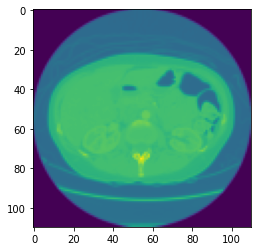

In [40]:
temp_y = y_0[:,:,:,1].reshape((8800, 110))
plt.imshow(temp_y[:110,:])

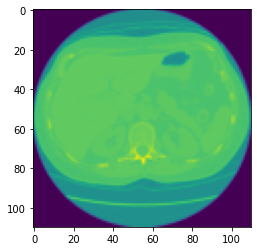

In [41]:
plt.imshow(temp_y[110:220, :])

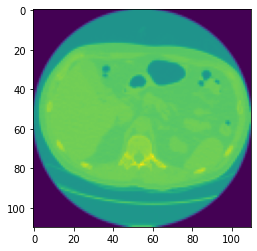

In [42]:
plt.imshow(temp_y[880:990, :])

In [43]:
y_0[:,:,:,1].shape

(80, 110, 110)

In [44]:
from sklearn.preprocessing import MinMaxScaler

In [84]:
x = np.empty((66,110,110, 3))
for i in range(66):
    #x[i,:,:,0] = np.flipud(x_train_0[i]).T
    for j in range(3):
        x[i,:,:,j] = x_train_0[i]

y = y_train
x.shape, y.shape

((66, 110, 110, 3), (66, 110, 88, 110))

In [85]:
x_test_temp = np.empty((15,110,110, 3))
for i in range(15):
    for j in range(3):
        x_test_temp[i,:,:,j] = x_test_0[i]


y_test_temp = y_test
x_test_temp.shape, y_test_temp.shape

((15, 110, 110, 3), (15, 110, 88, 110))

In [47]:
x.min(), x_test_temp.min()

(-0.08876650985184173, -0.03157338801359691)

In [91]:
x = x + 0.1
x_test_temp += 0.1

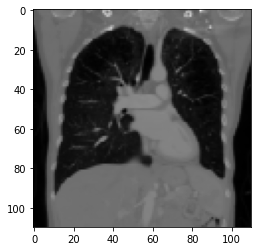

In [49]:
plt.imshow(x[0,:,:, 0], cmap = 'gray')

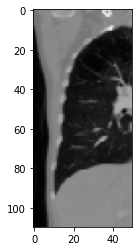

In [50]:
plt.imshow(x[0,:, :50, 0], cmap = 'gray')

In [51]:
(y_0[:66,:,:,0] - x_train_0).max()

0.0669857189426884

In [52]:
(y_0[:66,:,:,0] - x_train_0).min(), (y_0[:66,:,:,0] - x_train_0).mean(), (y_0[:66,:,:,0] - x_train_0).max()

(-0.1559427395745255, -0.0139788865957183, 0.0669857189426884)

In [53]:
from keras.layers import BatchNormalizationV1

In [54]:
vgg_19 = VGG19(input_shape=(110,110,3), weights='imagenet', include_top=False)
for layer in vgg_19.layers[:10]:
    layer.trainable = False
input = vgg_19.layers[:5]

80150528/80134624 [==============================] - 1s 0us/step


In [86]:
vgg_16 = VGG16(input_shape=(110,110,3), weights='imagenet', include_top=False)
for layer in vgg_16.layers[:10]:
    layer.trainable = False
input_16 = vgg_16.layers[:5]
vgg_19 = VGG19(input_shape=(110,110,3), weights='imagenet', include_top=False)
for i,layer in enumerate(vgg_19.layers[:10]):
    layer.trainable = False
    layer._name = layer.name + str(i)
input_19 = vgg_19.layers[:5]

model = Sequential()
model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu', input_shape = (110,110,3)))    #LeakyReLU(alpha=1)
model.add(input_16[0])
model.add(input_16[1])
model.add(input_16[2])
model.add(input_19[0])
#model.add(input_19[1])
model.add(input_19[2])

model.add(BatchNormalizationV1())
model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
#model.add(BatchNormalizationV1())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))

model.add(Conv2D(filters=110, kernel_size=(1,23), padding="valid", activation=LeakyReLU(alpha=1)))
#model.add(BatchNormalization())
model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
#model.add(BatchNormalization())

model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 110, 110, 3)       84        
_________________________________________________________________
input_6 (InputLayer)         multiple                  0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 110, 110, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 110, 110, 64)      36928     
_________________________________________________________________
input_70 (InputLayer)        multiple                  0         
_________________________________________________________________
block1_conv22 (Conv2D)       (None, 110, 110, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 110, 110, 64)     

In [87]:
model.compile(optimizer= 'adam' , loss = 'mean_squared_error', metrics = ['accuracy'])                  #  Adam(learning_rate = 0.0001)
history = model.fit(x, y, batch_size=32, validation_data=(x_test_temp, y_test_temp), epochs = 10)

Epoch 1/10
3/3 [==============================] - 60s 16s/step - loss: 0.9017 - accuracy: 0.0103 - val_loss: 241.3642 - val_accuracy: 0.0061
Epoch 2/10
3/3 [==============================] - 58s 16s/step - loss: 0.2122 - accuracy: 0.0074 - val_loss: 647.3964 - val_accuracy: 0.0098
Epoch 3/10
3/3 [==============================] - 58s 16s/step - loss: 0.1076 - accuracy: 0.0077 - val_loss: 655.9484 - val_accuracy: 0.0102
Epoch 4/10
3/3 [==============================] - 58s 16s/step - loss: 0.0645 - accuracy: 0.0078 - val_loss: 513.9755 - val_accuracy: 0.0104
Epoch 5/10
3/3 [==============================] - 58s 16s/step - loss: 0.0485 - accuracy: 0.0072 - val_loss: 305.1544 - val_accuracy: 0.0071
Epoch 6/10
3/3 [==============================] - 58s 16s/step - loss: 0.0347 - accuracy: 0.0125 - val_loss: 224.9075 - val_accuracy: 0.0055
Epoch 7/10
3/3 [==============================] - 58s 16s/step - loss: 0.0251 - accuracy: 0.0144 - val_loss: 123.1312 - val_accuracy: 0.0064
Epoch 8/10
3/

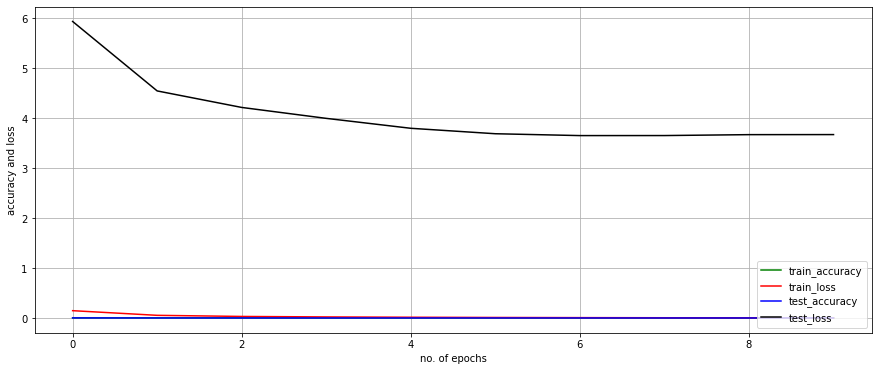

In [74]:
plot_learning_curve(history)

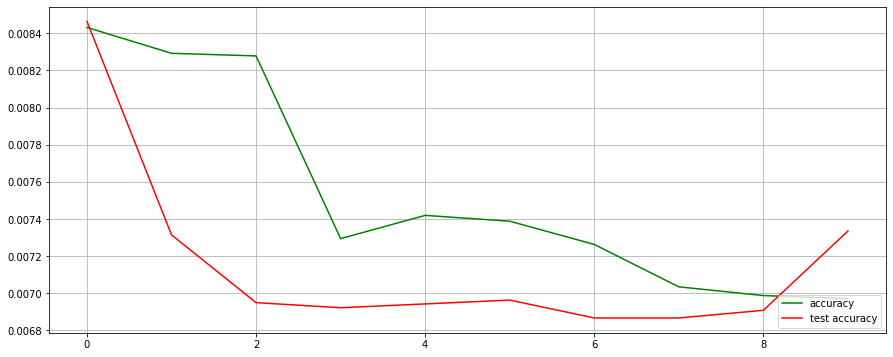

In [75]:
plot_accuracy_curve(history)

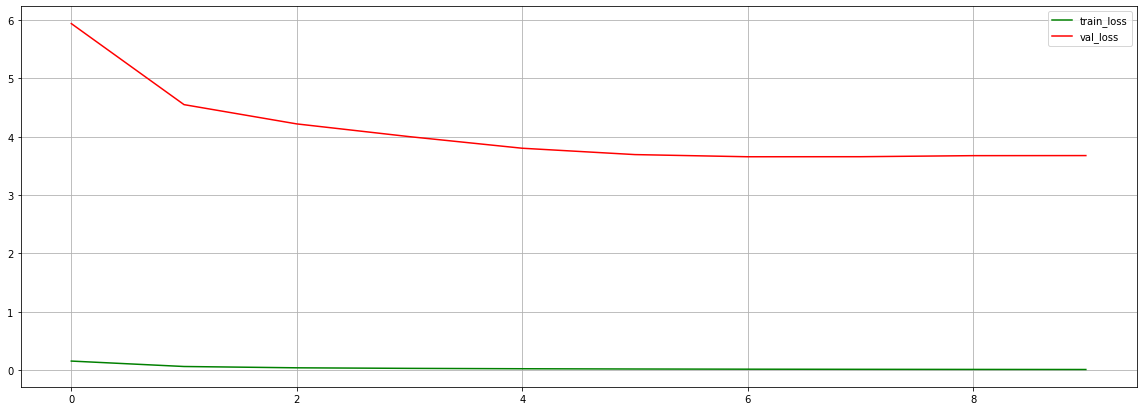

In [76]:
plot_loss_curve(history)

In [60]:
scaler = MinMaxScaler()
x_temp = scaler.fit_transform(x.reshape((66*110*110*3, 1)))
x_temp = x_temp.reshape((66, 110, 110, 3))
x_test_temp = scaler.transform(x_test_temp.reshape((15*110*110*3, 1))).reshape(15, 110, 110, 3)

In [61]:
scaler = MinMaxScaler()
y_temp = scaler.fit_transform(y.reshape((66*110*88*110, 1)))
y_temp = y_temp.reshape((66, 110, 88, 110))
y_test_temp = scaler.transform(y_test_temp.reshape((15*110*88*110, 1))).reshape(15, 110, 88, 110)

In [62]:
x_test_temp.min(), y_test_temp.min()

(0.3135016262705489, 0.0)

In [63]:
x_temp.min()

0.0

In [64]:
x_test_temp.min(), y_test_temp.min()

(0.3135016262705489, 0.0)

In [65]:
x = x+0.1
y = y+0.1
x_test_temp = x_test_temp+0.1
y_test_temp = y_test_temp+0.1

In [66]:
tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta')

tf.keras.optimizers.Adagrad(learning_rate=0.0008, initial_accumulator_value=0.1, epsilon=1e-07, name = 'Adagrad')

tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')

tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adamax')

tf.keras.optimizers.Ftrl(learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1,l1_regularization_strength=0.0,
                         l2_regularization_strength=0.0, name='Ftrl', l2_shrinkage_regularization_strength=0.0, beta=0.0)

tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')



In [67]:
vgg_16 = VGG16(input_shape=(110,110,3), weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [98]:
vgg_16 = VGG16(input_shape=(110,110,3), weights='imagenet', include_top=False)
for layer in vgg_16.layers[:10]:
    layer.trainable = False
input = vgg_16.layers[:5]
model = Sequential()
model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu', input_shape = (110,110,3)))    #LeakyReLU(alpha=1)
model.add(input[0])
model.add(input[1])
model.add(input[2])

model.add(Conv2D(filters=110, kernel_size=(1,23), padding="valid", activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation='relu'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 110, 110, 3)       84        
_________________________________________________________________
input_11 (InputLayer)        multiple                  0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 110, 110, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 110, 110, 64)      36928     
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 110, 88, 110)      162030    
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 110, 88, 110)      109010    
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 110, 88, 110)    

In [99]:
model.compile(loss = 'mean_squared_error', optimizer= 'adam', metrics = ['accuracy'])                        # Adam(learning_rate=0.0008)
history = model.fit(x, y, batch_size=32, validation_data=(x_test_temp, y_test_temp), epochs = 10)

Epoch 1/10
3/3 [==============================] - 38s 10s/step - loss: 0.4064 - accuracy: 0.0065 - val_loss: 0.0042 - val_accuracy: 0.0088
Epoch 2/10
3/3 [==============================] - 37s 10s/step - loss: 0.0036 - accuracy: 0.0122 - val_loss: 0.0015 - val_accuracy: 0.1289
Epoch 3/10
3/3 [==============================] - 37s 10s/step - loss: 0.0015 - accuracy: 0.1313 - val_loss: 0.0015 - val_accuracy: 0.1530
Epoch 4/10
3/3 [==============================] - 37s 10s/step - loss: 0.0015 - accuracy: 0.1552 - val_loss: 0.0015 - val_accuracy: 0.1532
Epoch 5/10
3/3 [==============================] - 37s 10s/step - loss: 0.0015 - accuracy: 0.1562 - val_loss: 0.0015 - val_accuracy: 0.1532
Epoch 6/10
3/3 [==============================] - 37s 10s/step - loss: 0.0015 - accuracy: 0.1566 - val_loss: 0.0015 - val_accuracy: 0.1535
Epoch 7/10
3/3 [==============================] - 37s 10s/step - loss: 0.0015 - accuracy: 0.1595 - val_loss: 0.0015 - val_accuracy: 0.1535
Epoch 8/10
3/3 [===========

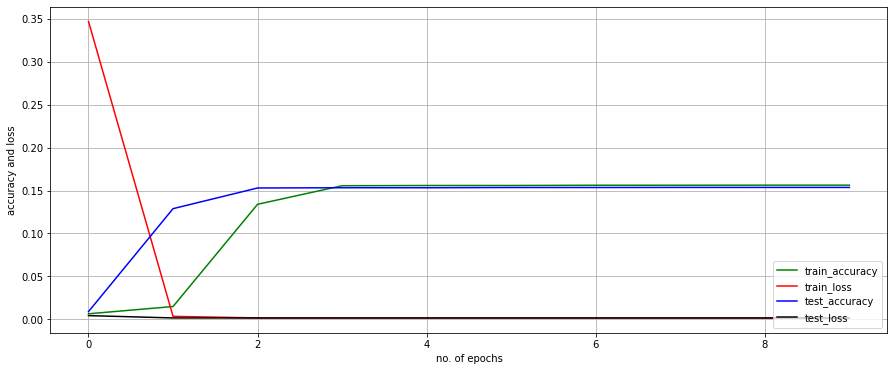

In [100]:
plot_learning_curve(history)

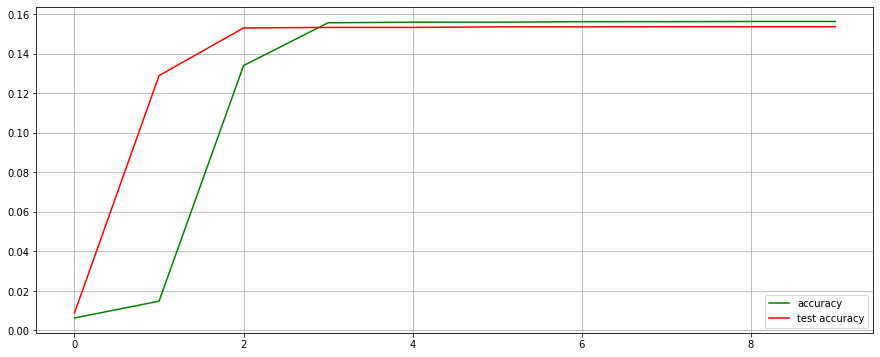

In [101]:
plot_accuracy_curve(history)

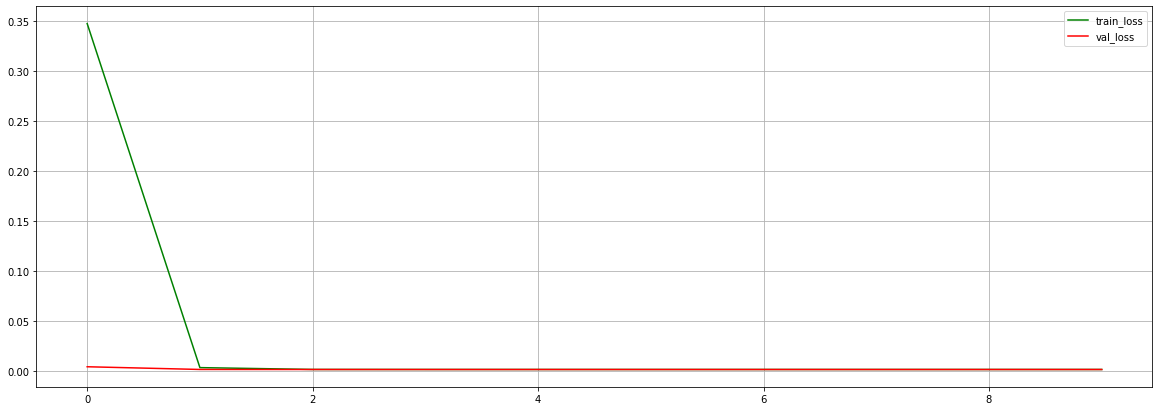

In [103]:
plot_loss_curve(history)

In [104]:
|

SyntaxError: ignored

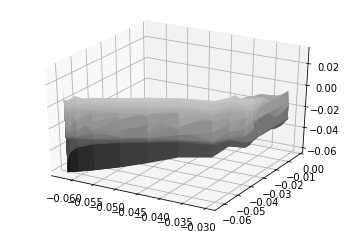

In [102]:
X = y_train_0[0,0,:,:]
Y = y_train_0[0,:,0,:]
Z = y_train_0[0,:,:,0]
ax = plt.axes(projection = '3d')
ax.plot_surface(X,Y,Z, rstride = 1, cstride = 1, cmap='gray', edgecolor = 'none')

In [ ]:
X = np.linspace(-6,6)

In [ ]:
from keras.applications.resnet import ResNet

In [ ]:
y_train_0.shape

In [ ]:
x.shape

In [ ]:
y = np.empty((66,88,110))
y_test_temp = np.empty((15,88,110))
for i in range(66):
    y = y_train[i][:,:,0].T
for i in range(15):
    y_test_temp = y_test[i][:,:,0].T

In [ ]:
model = Sequential()

model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation=LeakyReLU(alpha=1), input_shape = (110,110,3)))    #LeakyReLU(alpha=1)
#model.add(Conv2D(filters=110, kernel_size=(1,23), padding="valid", activation=LeakyReLU(alpha=1)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
#model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
model.add(Conv2D(filters=110, kernel_size=(1,23), padding="valid", activation=LeakyReLU(alpha=1)))

model.summary()

In [ ]:
model = Sequential()

model.add(Conv1D(filters=110, kernel_size=3, padding='same', activation=LeakyReLU(alpha=1), input_shape = (88,110)))    #LeakyReLU(alpha=1)
#model.add(Conv2D(filters=110, kernel_size=(1,23), padding="valid", activation=LeakyReLU(alpha=1)))
model.add(Conv1D(filters=64, kernel_size=3, padding="same", activation=LeakyReLU(alpha=1)))
model.add(Conv1D(filters=32, kernel_size=3, padding="same", activation=LeakyReLU(alpha=1)))
model.add(Conv1D(filters=16, kernel_size=3, padding="same", activation=LeakyReLU(alpha=1)))
#model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation=LeakyReLU(alpha=1)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation=LeakyReLU(alpha=1)))
##model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation=LeakyReLU(alpha=1)))
#model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation=LeakyReLU(alpha=1)))
#model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=1)))
model.add(Conv1D(filters=1, kernel_size=3, padding="same", activation=LeakyReLU(alpha=1)))

model.summary()

In [ ]:
model.compile(loss = 'mean_squared_error', optimizer= Adam(learning_rate=0.0005), metrics = ['accuracy'])                        # Adam(learning_rate=0.0008)Adagrad
history = model.fit(y, x[:,:, :1, 0], batch_size=32, validation_data=(y_test_temp, x_test_temp[:,:,:1,0]), epochs = 50)

In [ ]:
x[:,:, :1, 0].shape, y.shape

In [ ]:
plot_learning_curve(history)

In [ ]:
plot_loss_curve(history)

In [ ]:
vgg_19 = VGG19(input_shape=(110,110,3), weights='imagenet', include_top=False)
for layer in vgg_19.layers[:10]:
    layer.trainable = False
input = vgg_19.layers[:5]
model = Sequential()
model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu', input_shape = (110,110,3)))    #LeakyReLU(alpha=1)
model.add(input[0])
model.add(input[1])
model.add(input[2])

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu'))
model.add(Conv2D(filters=96, kernel_size=(3,3), padding="same", activation='relu'))
model.add(Conv2D(filters=96, kernel_size=(3,3), padding="same", activation='relu'))

model.add(Conv2D(filters=110, kernel_size=(1,23), padding="valid", activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation='relu'))
#model.add(x[3])
#model.add(x[4])
#model = Model()
model.summary()

In [ ]:
model.compile(loss = 'mean_squared_error', optimizer= 'adam', metrics = ['accuracy']) 
history = model.fit(x, y, batch_size=32, validation_data=(x_test_temp, y_test_temp), epochs = 20)

In [ ]:
plot_learning_curve(history, 20)

In [ ]:
plot_accuracy_curve(history, 20)

In [ ]:
vgg_16 = VGG16(input_shape=(110,110,3), weights='imagenet', include_top=False)
for layer in vgg_16.layers[:10]:
    layer.trainable = False
input_16 = vgg_16.layers[:5]
vgg_19 = VGG19(input_shape=(110,110,3), weights='imagenet', include_top=False)
for i,layer in enumerate(vgg_19.layers[:10]):
    layer.trainable = False
    layer._name = layer.name + str(i)
input_19 = vgg_19.layers[:5]

model = Sequential()
model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu', input_shape = (110,110,3)))    #LeakyReLU(alpha=1)
model.add(input_16[0])
model.add(input_16[1])
model.add(input_16[2])
model.add(input_19[0])
#model.add(input_19[1])
model.add(input_19[2])

model.add(Conv2D(filters=110, kernel_size=(1,23), padding="valid", activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation='relu'))
#model.add(x[3])
#model.add(x[4])
#model = Model()
model.summary()

In [ ]:
from keras.applications import  efficientnet, imagenet_utils, inception_resnet_v2, inception_v3, mobilenet, mobilenet_v2, mobilenet_v3, nasnet, resnet50, resnet_v2, vgg16, vgg19, xception

In [ ]:
l1 = ['densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']

In [ ]:
l2 = [['DenseNet121', 'DenseNet169', 'DenseNet201'], ['EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB7'] , 'decode_predictions', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'NASNetMobile', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception']

In [ ]:
l = ['EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7']

In [ ]:
def check_model(l1, l2):
    for k,i in enumerate(l1):
        for j in l2[k]:    
            vgg = i[:].j(input_shape=(110,110,3), weights='imagenet', include_top=False)
            for layer in vgg_19.layers[:10]:
                layer.trainable = False
            input = vgg_19.layers[:5]
            model = Sequential()
            model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu', input_shape = (110,110,3)))    #LeakyReLU(alpha=1)
            model.add(input[0])
            model.add(input[1])
            model.add(input[2])


            model.add(Conv2D(filters=110, kernel_size=(1,23), padding="valid", activation='relu'))
            model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation='relu'))
            #model.add(x[3])
            #model.add(x[4])
            #model = Model()
            model.summary()

In [ ]:
score = list()

In [ ]:
#EfficientNetB = 'EfficientNetB' + str(i)
efficient = efficientnet.EfficientNetB7(input_shape=(110,110,3), weights='imagenet', include_top=False)
for layer in efficient.layers[:10]:
    layer.trainable = False
input = vgg_19.layers[:5]
model = Sequential()
model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu', input_shape = (110,110,3)))    #LeakyReLU(alpha=1)
model.add(input[0])
model.add(input[1])
model.add(input[2])


model.add(Conv2D(filters=110, kernel_size=(1,23), padding="valid", activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation='relu'))
    #model.add(x[3])
    #model.add(x[4])
    #model = Model()
model.summary()

model.compile(loss = 'mean_squared_error', optimizer= 'adam', metrics = ['accuracy']) 
history = model.fit(x, y, batch_size=32, epochs = 10)
score.append(history.history['accuracy'])

In [ ]:
score

In [ ]:
plt.figure(figsize=(22,8))
color = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'cyan']
for i in range(8):
    plt.plot(np.arange(0, 10), score[i], color = color[i], label = color[i] + '_' + str(i))
    plt.legend()
    plt.grid()

In [ ]:
efficient = efficientnet.EfficientNetB7(input_shape=(110,110,3), weights='imagenet', include_top=False)
for layer in efficient.layers[:10]:
    layer.trainable = False
input = vgg_19.layers[:5]
model = Sequential()
model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu', input_shape = (110,110,3)))    #LeakyReLU(alpha=1)
model.add(input[0])
model.add(Conv2D(filters=3, kernel_size=(3,3), padding="same", activation='relu'))
#model.add(input[1])
model.add(Conv2D(filters=3, kernel_size=(3,3), padding="same", activation='relu'))
#model.add(input[2])

model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation='relu'))

model.add(Conv2D(filters=110, kernel_size=(1,23), padding="valid", activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(3,3), padding="same", activation='relu'))
    #model.add(x[3])
    #model.add(x[4])
    #model = Model()
model.summary()

model.compile(loss = 'mean_squared_error', optimizer= Adam(learning_rate=0.0005), metrics = ['accuracy']) 
history = model.fit(x, y, batch_size=32, validation_data=(x_test_temp, y_test_temp), validation_batch_size=32, epochs = 20)

In [ ]:
plot_learning_curve(history, 20)

In [ ]:
pd.read_csv('/content/Response EXP1 - AI_instances.csv')

In [ ]:
pd.read_csv('/content/Response EXP1 - AI_patients.csv')

In [ ]:
pd.read_csv('/content/Response EXP1 - Reviewer 1_instances.csv')

In [ ]:
pd.read_csv('/content/Response EXP2 - Reviewer 1_instances.csv')

In [ ]:
pd.read_csv('/content/labels_exp1.csv')

In [ ]:
plt.imshow(x_train_0[0], cmap = 'gray')

In [ ]:
plt.imshow(np.flipud(x_train_0[0])[:, :], cmap = 'gray')

In [ ]:
plt.imshow(y_0[0, :, :,100], cmap = 'gray')